### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [1]:
import HPO

import pysgpp

import matplotlib.pyplot as plt

import tensorflow as tf

import sklearn.metrics

from sklearn.model_selection import KFold

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor, KerasClassifier


VERBOSE = 1
CV = 3#[(slice(None), slice(None))]
TESTING = False

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

2023-04-25 15:07:01.404605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 15:07:02.930442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameter space definition

In [2]:
ITER = 8

hyperparameterspace = {
    'epochs': ["interval-int", 1, 20],
    'batch_size': ["interval-int", 10, 200],
    'optimizer__learning_rate': ["interval-log", 0.0000001, 0.1],
    #'model__neurons_per_layer': ["interval-int", 1, 100],
    #'model__number_of_layers': ["interval-int", 1, 10],
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

In [3]:
ids = [233214, 233211]#, 359935, 359952, 359940, 359931, 317614, 359949, 359934, 359946, 359938, 359932, 359943]

def relu_advanced(x):
    return K.relu(x)

ACTIVATION_FUNCTION = relu_advanced

INITIALIZER = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3, seed=42)

valid_datasets = 0
for i in range(len(ids)):
    print("######################################################################################################################################################")
    print("Current Dataset:", (i+1), "of", len(ids), "with id:", ids[i])

    dataset = HPO.Dataset(ratio=0.9, task_id=ids[i])

    ################## MODEL AND FUNCTION DEFINITION ####################

    # Function to create model, required for KerasClassifier
    def create_model(neurons_per_layer=40, number_of_layers=1): 
        # create model
        model = Sequential()
        model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION, kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
        for _ in range(number_of_layers):
            model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION, kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
        model.add(Dense(1, activation=None))

        optimizer = keras.optimizers.Adam(learning_rate=0.001)

        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model
    
    def evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers):
        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION, kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
            for _ in range(number_of_layers):
                model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION, kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
            model.add(Dense(1, activation=None))
            # Compile model
            
            optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

            model.compile(loss=loss, optimizer=optimizer)
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        kfold = KFold(n_splits=CV)

        X = dataset.get_X_train().tolist() + dataset.get_X_validation().tolist()
        Y = dataset.get_Y_train().tolist() + dataset.get_Y_validation().tolist()
        
        if TESTING:
            X += dataset.get_X_test().tolist()
            Y += dataset.get_Y_test().tolist()

        X = np.array(X)
        Y = np.array(Y)

        split = (kfold.split(X, Y))

        values = []

        for i, (train_index, test_index) in enumerate(split):
            X_train = X[train_index]
            Y_train = Y[train_index]

            X_val = X[test_index]
            Y_val = Y[test_index]

            model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)

            Y_predicted = model.predict(X_val)
            error = sklearn.metrics.mean_squared_error(Y_predicted, Y_val)
            values.append(error)

        result = sum(values)/len(values)
        K.clear_session()
        del model
        return result


    def blackboxfunction(params):
        #index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
        
        epochs = int(params[0])

        batch_size = int(params[1])

        model_learning_rate = params[2]

        neurons_per_layer = 40 # int(params[3])

        number_of_layers = 1 # int(params[4])

        return evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers)
        
    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(len(hyperparameterspace.keys()))


        def eval(self, x):
            #index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
            
            epochs = int(HPO.from_standard(hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

            batch_size = int(HPO.from_standard(hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

            model_learning_rate = HPO.from_standard_log(hyperparameterspace_special["optimizer__learning_rate"][0], hyperparameterspace_special["optimizer__learning_rate"][1], x[2])
            
            neurons_per_layer = 40 # int(HPO.from_standard(hyperparameterspace_special["model__neurons_per_layer"][0], hyperparameterspace_special["model__neurons_per_layer"][1], x[3]))

            number_of_layers = 1 # int(HPO.from_standard(hyperparameterspace_special["model__number_of_layers"][0], hyperparameterspace_special["model__number_of_layers"][1], x[4]))

            return evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers)
            

    ##### For each dataset: run models with different budget #####

    for j in range(ITER):
        BUDGET = (j+1) * 10
        print("\n################################################## Current Budget:", BUDGET, "##################################################")

        ############################## GRID SEARCH #######################
        print("Performing grid search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.GridSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        if VERBOSE > 0:
            print("Best params found by grid search:")
            print(result.best_params_)
        
        Y_predicted = result.predict(dataset.get_X_test())

        GRID_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        GRID_COST.append(cost)

        K.clear_session()
        del model

        ########################### RANDOM SEARCH #######################
        print("Performing random search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.RandomSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        if VERBOSE > 0:
            print("Best params found by random search:")
            print(result.best_params_)

        Y_predicted = result.predict(dataset.get_X_test())

        RANDOM_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        RANDOM_COST.append(cost)

        K.clear_session()
        del model 

        ########################### BAYESIAN OPT ##################### 
        print("Performing bayesian optimization")

        optimization = HPO.BayesianOptimization(dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)


        result = optimization.fit()
        
        index_best = 0
        for m in range(len(result[1])):
            if result[1][m] == max(result[1]):
                index_best = m

        best_score = result[1][index_best]
        best_params = result[0][index_best]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            i = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(best_params[i]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " + str(hyperparameterspace_special[key][index]))
                else:
                    print(key + ": " + str(best_params[i]))
                i += 1

        TESTING = True
        BAYESIAN_RESULT.append(blackboxfunction(best_params))
        TESTING = False

        BAYESIAN_COST.append(BUDGET)

        K.clear_session()

        ########################### SPARSE OPT ############################
        print("Performing sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.95, optimizer="gradient_descent")

        result = optimization.fit()

        TESTING = True
        SPARSE_RESULT.append(f.eval(result[0]))
        SPARSE_RESULT_OPTIMIZED.append(f.eval(result[1]))
        TESTING = False

        SPARSE_COST.append(result[2])
        SPARSE_COST_OPTIMIZED.append(result[2])

        K.clear_session()


        print(GRID_RESULT)
        print(RANDOM_RESULT)
        print(BAYESIAN_RESULT)
        print(SPARSE_RESULT)
        print(SPARSE_RESULT_OPTIMIZED)
    


######################################################################################################################################################
Current Dataset: 1 of 1 with id: 233214

################################################## Current Budget: 32 ##################################################
Performing grid search
Fitting 3 folds for each of 32 candidates, totalling 96 fits


2023-04-25 15:07:10.914617: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Best params found by grid search:
{'batch_size': 57, 'epochs': 15, 'model__neurons_per_layer': 25, 'model__number_of_layers': 7, 'optimizer__learning_rate': 9.999999999999994e-08}
Performing random search
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best params found by random search:
{'batch_size': 126, 'epochs': 5, 'model__neurons_per_layer': 9, 'model__number_of_layers': 9, 'optimizer__learning_rate': 0.0013919882077928997}
Performing bayesian optimization
Iterations took 492.4851515771006 seconds
With Hyperparameters: 
epochs: 20.0
batch_size: 198.5888244893411
optimizer__learning_rate: 1e-07
model__neurons_per_layer: 92.27477130297567
model__number_of_layers: 10.0
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 402673ms.
Solving linear system (automatic method)...
Done in 5ms.

Optimal hyperparameters so far:
epochs: 10.5
batch_size: 105.0
optimizer__learning_rate: 0.003162277660168

[3.4719634]
[0.9142854]
[5852062436.674666]
[2.2560569787586857]
[2.595044025038908]
Current dataset: 0 with name id: 233214


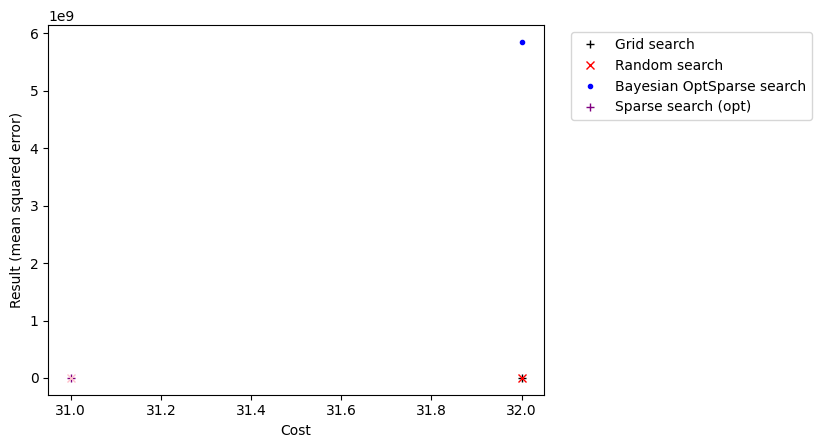

In [4]:
print(GRID_RESULT)
print(RANDOM_RESULT)
print(BAYESIAN_RESULT)
print(SPARSE_RESULT)
print(SPARSE_RESULT_OPTIMIZED)
count = 0
for i in range(len(ids)):
    print("Current dataset:", i, "with name id:", ids[i])
    for j in range(ITER):
        plt.plot(GRID_COST[count], GRID_RESULT[count], '+', color='black')
        plt.plot(RANDOM_COST[count], RANDOM_RESULT[count], 'x', color='red')
        plt.plot(BAYESIAN_COST[count], BAYESIAN_RESULT[count], '.', color='blue')
        plt.plot(SPARSE_COST[count], SPARSE_RESULT[count], '+', color='purple')
        plt.plot(SPARSE_COST_OPTIMIZED[count], SPARSE_RESULT_OPTIMIZED[count], 'x', color='pink')
        plt.xlabel("Cost")
        plt.ylabel("Result (mean squared error)")
        #plt.yscale("log")
        plt.legend(["Grid search", "Random search", "Bayesian Opt" "Sparse search", "Sparse search (opt)"], bbox_to_anchor=(1.04, 1), loc="upper left")
        count += 1
    plt.show()

